In [1]:
import pickle
import yaml
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

SAVE_PATH = Path(os.path.abspath("")).parent / "_static"
RESULTS_PATH = Path(os.path.abspath("")).parent / "results" / "mnist" 

In [2]:
def saveFig(name, fig):
    fig.savefig(
        name,
        dpi=None,
        facecolor=fig.get_facecolor(),
        edgecolor="none",
        orientation="portrait",
        format="png",
        transparent=False,
        bbox_inches="tight",
        pad_inches=0.2,
        metadata=None,
    )

In [3]:
# Update the path belows to the multirun directories containing the results for FedProx and FedAvg
path_fedprox_results = RESULTS_PATH / "FedProx"
path_fedavg_results = RESULTS_PATH / "FedAvg"

In [4]:
# load all results
def read_pickle_and_config(path_to_pickle):
    with open(path_to_pickle, "rb") as handle:
        data = pickle.load(handle)

    config_path = Path(path_to_pickle).parent / "config.json"
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)

    return data, config


# loads results.pkl and config of each run
def process_data(path_fedprox_results):
    res_list = []
    for results in list(Path(path_fedprox_results).glob("**/*.pkl")):
        data, config = read_pickle_and_config(results)
        data_cen = data["history"].metrics_centralized
        loss_cen = data["history"].losses_centralized
        stragglers = config["algorithm"]["stragglers_fraction"]
        res_list.append(
            {
                "stragglers": stragglers,
                "mu": config["algorithm"]["mu"],
                "accuracy": np.array([d[1] for d in data_cen["accuracy"]]),
                "loss": np.array([d[1] for d in loss_cen]),
            }
        )

    # to DataFrame
    df = pd.DataFrame.from_dict(res_list)
    # Grouping the DataFrame by 'mu' and 'stragglers' columns
    grouped_df = df.groupby(["mu", "stragglers"])

    # Calculating the mean and standard deviation of 'accuracy' and 'loss' columns
    mean_df = grouped_df[["accuracy", "loss"]].mean()
    return mean_df.reset_index()

In [5]:
fedprox_df = process_data(path_fedprox_results)
fedavg_df = process_data(path_fedavg_results)

KeyError: 'mu'

In [6]:
# let's add a new column to each dataframe that we'll use as label
fedprox_df["strategy"] = "FedProx"
fedavg_df["strategy"] = "FedAvg"

# Now let's fuse both datframes
df = pd.concat([fedavg_df, fedprox_df])
df = df.reset_index()
df

,index,mu,stragglers,accuracy,loss,strategy
0,0,0.0,0.0,"[0.10392923369919312, 0.16772916353430561, 0.2...","[0.32773746219737865, 6.220423017389128, 3.842...",FedAvg
1,1,0.0,0.5,"[0.09652683806946324, 0.1645817671528091, 0.25...","[0.31677367721817723, 1.273924464232604, 3.868...",FedAvg
2,2,0.0,0.9,"[0.10062146043201525, 0.13034631383751819, 0.1...","[0.30501320970295626, 0.7084248083961617, 0.70...",FedAvg
3,0,0.0,0.0,"[0.09513857565278404, 0.31034430912644717, 0.3...","[0.3381236254012848, 2.857453445050956, 2.5510...",FedProx
4,1,0.0,0.5,"[0.09035232797073123, 0.2079987971733574, 0.24...","[0.3416075607920531, 4.532534890605508, 2.9091...",FedProx
5,2,0.0,0.9,"[0.09578008319550946, 0.2336991931037939, 0.21...","[0.3151989205274427, 3.769664958767745, 4.8151...",FedProx
6,3,2.0,0.0,"[0.10117776775422242, 0.1190146845085952, 0.10...","[0.31404021763893586, 6.455893467826807, 6.529...",FedProx
7,4,2.0,0.5,"[0.10581366210594897, 0.10038089510349321, 0.1...","[0.3134276013604228, 5.138224959183485, 6.8362...",FedProx
8,5,2.0,0.9,"[0.10605923921214855, 0.10723199518869345, 0.0...","[0.2920375537515039, 7.671658805158332, 9.2038...",FedProx


In [14]:
def viz(dataframe):
    fig, axs = plt.subplots(figsize=(18, 12), nrows=2, ncols=3)
    for row_idx, col_label in enumerate(["loss", "accuracy"]):
        for col_idx, strag_ratio in enumerate([0.0, 0.5, 0.9]):
            ax = axs[row_idx, col_idx]
            exp_data = dataframe.loc[(dataframe["stragglers"] == strag_ratio)]
            for _, exp in exp_data.iterrows():
                y = exp[col_label]
                rounds_array = np.array(range(len(y)))
                label = exp["strategy"]
                label = f"{label}($\mu$={exp['mu']})" if label == "FedProx" else label
                ax.plot(rounds_array, y, label=label, linewidth=2.0)

            ax.grid()
            ax.legend(fontsize=14)
            ax.set_xlabel("Round", fontsize=14)
            ax.set_ylabel("Loss" if row_idx == 0 else "Accuracy", fontsize=14)

            ax.tick_params(axis="both", which="major", labelsize=14)
            ax.tick_params(axis="both", which="minor", labelsize=14)

            if row_idx == 0:
                ax.set_title(f"{int(strag_ratio*100)}% Stragglers", fontsize=14)
    return fig

<>:11: DeprecationWarning: invalid escape sequence '\m'


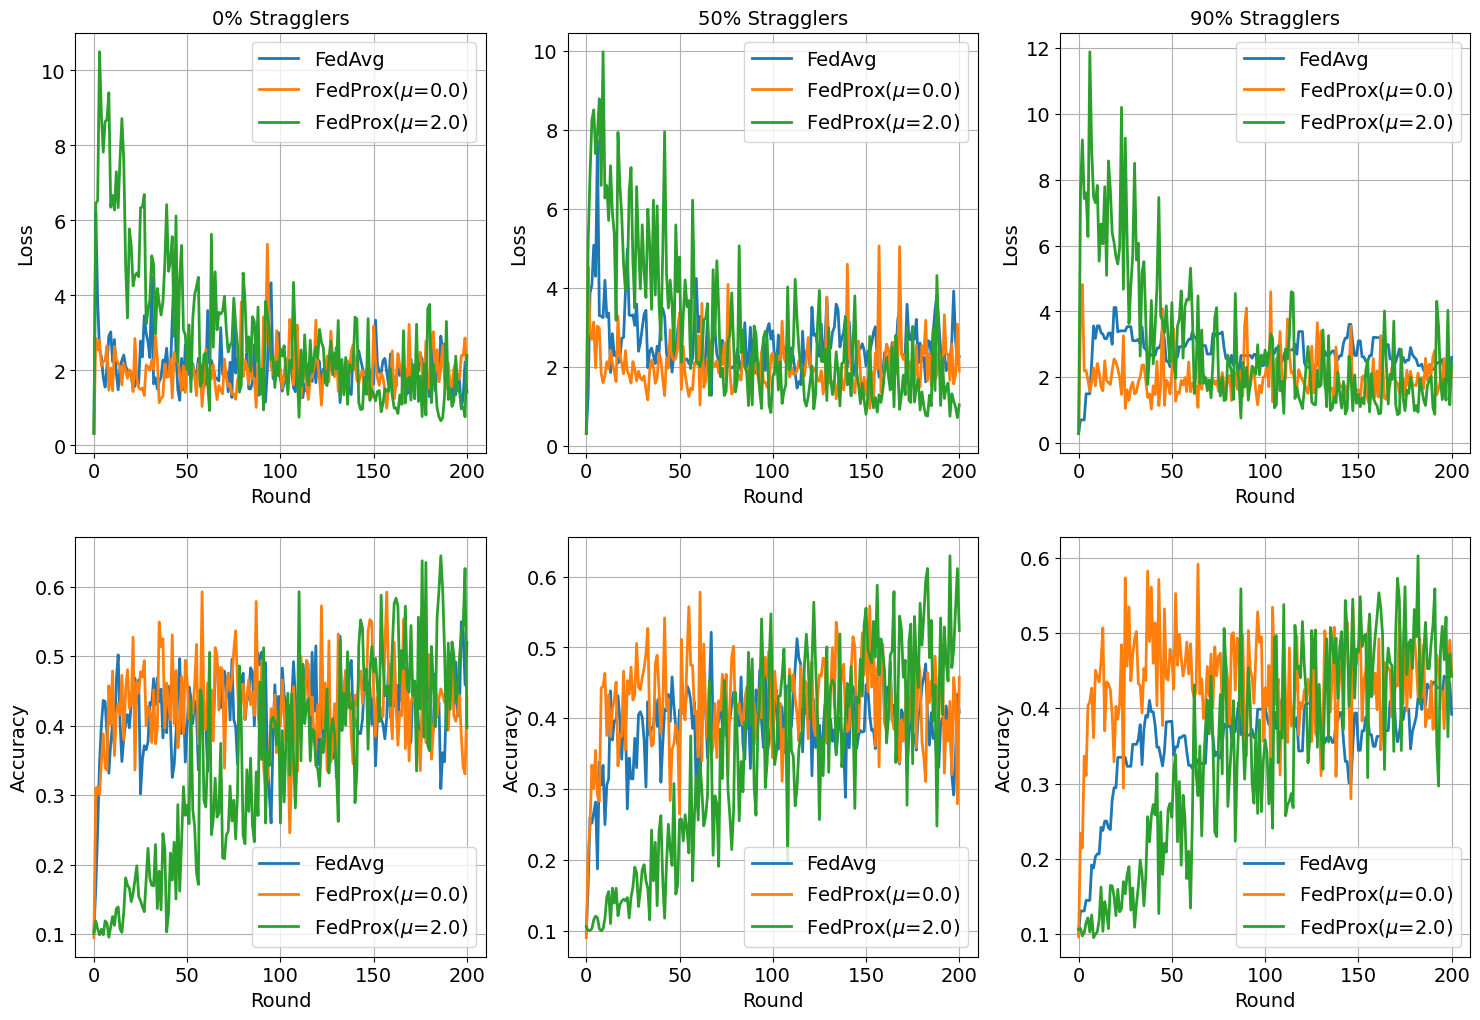

In [15]:
f = viz(df)

In [ ]:
saveFig(SAVE_PATH/"FedProx_mnist.png", f)